In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

### Clean cryptic seq data

In [3]:
data = []
for excel_file in ['CTB043.sites.annotated.xlsx', 'CTB058.sites.annotated.xlsx']:
    # Read all sheets from both Excel files
    sheet_dict_1 = pd.read_excel(excel_file, sheet_name=None)

    # Drop 'sites_collated' and 'genes' from sheet_dict
    sheet_dict = {key: value for key, value in sheet_dict_1.items() if key not in ['sites_collated', 'genes', 'NC']}

    # Concatenate all sheets into a single DataFrame
    combined_df = pd.concat(sheet_dict.values(), ignore_index=True)
    data.append(combined_df)

df = pd.concat(data)

# Select the specified columns
selected_columns = ['reference_name', 'dinucleotide_position', 'strand', 'attachment_site', 'genome_dinucleotide', 'seq_start', 'seq_end', 'count', 'seq']

# Create a new DataFrame with only the selected columns. Keep only canonical recombination.
df = df[df['recombination'] == 'canonical']
df = df[selected_columns]

In [36]:
groups = df.groupby(['reference_name', 'seq_start', 'seq_end']).size()
(groups > 1).sum()/len(groups)

0.42812569354691316

In [4]:
# Group by genomic coordinates and take the mean of count, ignoring strand
df_deduped = df.groupby(['reference_name', 'seq_start', 'seq_end']).agg({
    'count': 'mean',
    'seq': 'first',
    'genome_dinucleotide': 'first'
}).reset_index()

In [5]:
# Save data
df_deduped.to_csv('train.csv', index=False)

### Explore cryptic seq data

In [6]:
dn_map = {
    'GG': 'GG/CC',
    'CC': 'GG/CC',
    'TC': 'TC/GA',
    'GA': 'TC/GA',
    'CT': 'CT/AG',
    'AG': 'CT/AG',
    'GT': 'GT/AC',
    'AC': 'GT/AC',
    'AA': 'AA/TT',
    'TT': 'AA/TT',
    'CA': 'CA/TG',
    'TG': 'CA/TG'
}
df_deduped['dn_pair']= df_deduped['genome_dinucleotide'].map(dn_map)

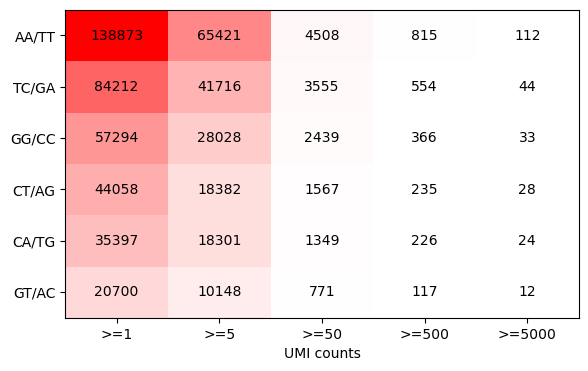

In [7]:
dinucleotides = ['AA/TT','TC/GA', 'GG/CC', 'CT/AG','CA/TG', 'GT/AC']
data = df_deduped

values = []
for threshold in [1, 5, 50, 500, 5000]:
    selected = data[data['count'] > threshold]
    values.append(selected['dn_pair'].value_counts().values)
values = np.array(values).transpose()

fig, ax = plt.subplots(figsize=(8,4))

# Create a red-white colormap
colors = [(1, 1, 1), (1, 0, 0)]  # Red to white
cmap = mcolors.LinearSegmentedColormap.from_list('redwhite', colors)

im = ax.imshow(values, aspect=0.5, cmap=cmap)

xlabels = ['>=1', '>=5', '>=50', '>=500', '>=5000']
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(5), labels=xlabels)
ax.set_yticks(np.arange(6), labels=dinucleotides)
ax.set_xlabel('UMI counts')

# Add numerical values to each cell
for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        text = ax.text(j, i, f'{values[i, j]:.0f}', ha='center', va='center', color='black')


Text(0.5, 0, 'Site')

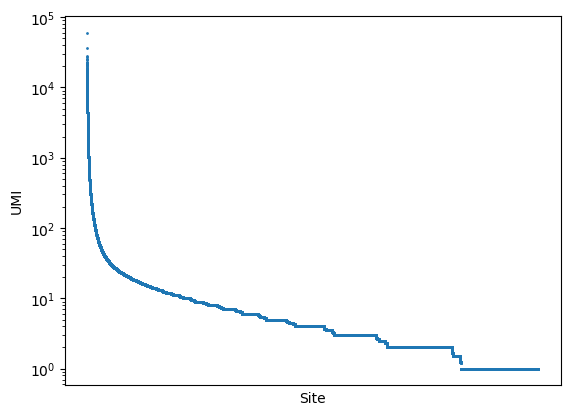

In [8]:
fig, ax = plt.subplots()
plt.scatter(np.arange(len(df_deduped)), df_deduped.sort_values('count', ascending=False)['count'].values, s=1)
ax.semilogy()
ax.set_ylabel('UMI')
ax.set_xticks([])
ax.set_xlabel('Site')

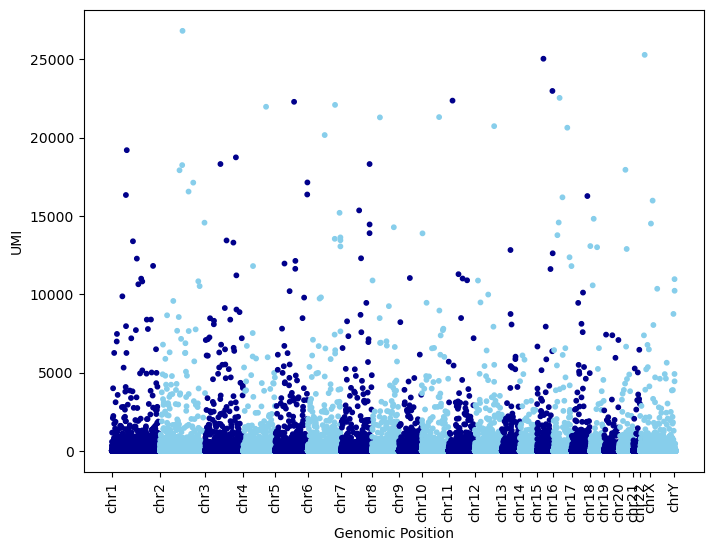

In [9]:
def manhattan_color_plot(df):
    df = df.copy()
    df['chr'] = df['reference_name']
    
    # Convert 'chr' to a categorical type with a specific order
    chromosome_order = [f'chr{i}' for i in range(1, 23)] + ['chrX', 'chrY']
    df['chr'] = pd.Categorical(df['chr'], categories=chromosome_order, ordered=True)
    df = df[df['chr'].notna()]

    # Sort the dataframe by 'chr' and then by 'seq_start'
    df_sorted = df.sort_values(by=['chr', 'seq_start']).reset_index()

    # Identify positions where 'chr' changes
    df_sorted['chr'] = df_sorted['chr'].astype(str)
    chr_ticks = df_sorted['chr'].ne(df_sorted['chr'].shift()).index[df_sorted['chr'].ne(df_sorted['chr'].shift())]
    chr_labels = df_sorted.loc[chr_ticks, 'chr']

    # Assign different colors for even and odd chromosomes
    even_color = '#87CEEB'
    odd_color = '#00008B'
    colors = []

    for chrom in df_sorted['chr']:
        # Check if the chromosome number is odd or even
        if chrom.startswith('chr') and chrom[3:].isdigit():
            chrom_num = int(chrom[3:])
            if chrom_num % 2 == 0:
                colors.append(even_color)
            else:
                colors.append(odd_color)
        else:
            # For chromosomes X and Y, you can assign one of the colors or handle separately
            colors.append(even_color if chrom in ['chrX', 'chrY'] else odd_color)

    # Plotting
    plt.figure(figsize=(8, 6))  # Increased figure size

    # Plot each chromosome with alternating colors
    plt.scatter(df_sorted.index, df_sorted['count'], c=colors, alpha=1, s=10)

    # Customizing x-ticks with chromosome labels
    plt.xticks(chr_ticks, chr_labels, rotation=90)
    plt.xlabel('Genomic Position')
    plt.ylabel('UMI')
    plt.show()

    return df


plot_df = manhattan_color_plot(df_deduped)

Text(0, 0.5, 'Bits')

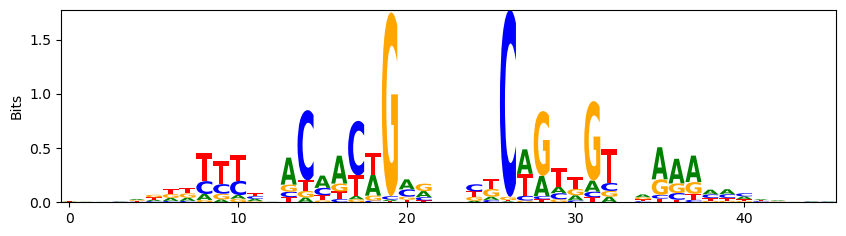

In [14]:
import logomaker

# Get sequences
df_thresholded = df_deduped[df_deduped['count'] >= 1]
sequences = df_thresholded.sort_values('count', ascending=False)['seq'].values[0:10000]
#sequences = [seq[:22] + 'NN' + seq[24:] for seq in sequences]


# Create the logo plot
count_matrix = logomaker.alignment_to_matrix(sequences)
probability_matrix = logomaker.transform_matrix(count_matrix, from_type='counts', to_type='probability')
weight_matrix = logomaker.transform_matrix(count_matrix, from_type='counts', to_type='weight')
entropy_matrix = logomaker.transform_matrix(count_matrix, from_type='counts', to_type='information')
entropy_matrix.iloc[22:24,:] = 0

logo = logomaker.Logo(entropy_matrix, shade_below=.5, fade_below=.5)
plt.ylabel('Bits')

In [13]:
probability_matrix.to_csv('PFM.csv', index=False, header=False)
weight_matrix.to_csv('PWM.csv', index=False, header=False)

Text(0, 0.5, 'Bits')

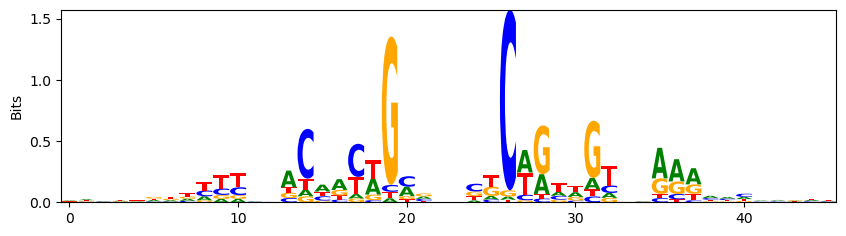

In [49]:
import logomaker

# Get sequences
df_thresholded = df_deduped[df_deduped['count'] < 5]
sequences = df_thresholded.sort_values('count', ascending=False)['seq'].values[0:10000]
#sequences = [seq[:22] + 'NN' + seq[24:] for seq in sequences]


# Create the logo plot
count_matrix = logomaker.alignment_to_matrix(sequences)
probability_matrix = logomaker.transform_matrix(count_matrix, from_type='counts', to_type='probability')
weight_matrix = logomaker.transform_matrix(count_matrix, from_type='counts', to_type='weight')
entropy_matrix = logomaker.transform_matrix(count_matrix, from_type='counts', to_type='information')
entropy_matrix.iloc[22:24,:] = 0

logo = logomaker.Logo(entropy_matrix, shade_below=.5, fade_below=.5)
plt.ylabel('Bits')

In [41]:
len(df_thresholded)

88